# → NGram

Detail of implementation of the [RecipeNgramModel](./ngram.py)

## ⬇️ Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Dict
import os
import optuna
import sys
import pickle
import random
import ast
import math
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

sys.path.append(os.path.abspath(".."))

# Preprocessing
from src.base_preprocessing import BasePreprocessing
from src.generator.pipelines.bpe_generator_preprocessing import BPEGeneratorPreprocessing
from src.generator.pipelines.autotokenizer_generator_preprocessing import AutotokenizerGeneratorPreprocessing
from src.generator.pipelines.keras_tokenizer_generator_preprocessing import KerasTokenizerGeneratorPreprocessing
from src.generator.pipelines.base_generator_preprocessing import BaseGeneratorPreprocessing
# Models
from src.generator.models.ngram import RecipeNGramModel

## ⭐ Base Preprocessing

In [4]:
if not os.path.exists("../../data/preprocessed_recipe.csv"):
    base_preprocessor = BasePreprocessing()
    raw_data = base_preprocessor.load('../../data/RAW_recipes.csv')
    data = base_preprocessor.transform(raw_data)
    data.to_csv("../../data/preprocessed_recipe.csv")
else:
    data = pd.read_csv("../../data/preprocessed_recipe.csv")
data.head()

,Unnamed: 0,id,name,minutes,n_steps,description,n_ingredients,steps_string_standardize,ingredients_text,tags_text,cuisine,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,0,137739,arriba baked squash mexican,55,11,autumn is my favorite time of year to cook! th...,7,make a choic and proceed with recip depend on ...,"['winter squash', 'mexican seasoning', 'mixed ...","['60-minutes-or-less', 'time-to-make', 'course...",North America – United States,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,1,31490,breakfast pizza,30,9,this recipe calls for the crust to be prebaked...,6,preheat oven to 103.33 celsius °c press dough ...,"['prepared pizza crust', 'sausage patty', 'egg...","['30-minutes-or-less', 'time-to-make', 'course...",North America – United States,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,4,44061,amish tomato ketchup canning,190,5,my dh's amish mother raised him on this recipe...,8,"mix all ingredients& boil for 2 30.0 minute , ...","['tomato juice', 'apple cider vinegar', 'sugar...","['weeknight', 'time-to-make', 'course', 'main-...",North America – United States,352.9,1.0,337.0,23.0,3.0,0.0,28.0
3,5,25274,marinated olive,15,4,my italian mil was thoroughly impressed by my ...,9,toast the fennel seed and lightli crush them p...,"['fennel seeds', 'green olives', 'ripe olives'...","['15-minutes-or-less', 'time-to-make', 'course...",North America – United States,380.7,53.0,7.0,24.0,6.0,24.0,6.0
4,6,67888,barbecued rib,120,10,this recipe is posted by request and was origi...,22,in a medium saucepan combin all the ingredi fo...,"['pork spareribs', 'soy sauce', 'fresh garlic'...","['weeknight', 'time-to-make', 'course', 'main-...",North America – United States,1109.5,83.0,378.0,275.0,96.0,86.0,36.0


In [3]:
data.shape

(80601, 18)

## Simple NGram with only base preprocessing

In [ ]:
step_preprocessing = BaseGeneratorPreprocessing()
ingredients, steps = step_preprocessing.fit_transform(data)

In [8]:
print(len(set([ingredient for ingredient, count in Counter(ingredient for recipe in ingredients for ingredient in recipe).items()])))

1484


/tmp/nix-shell-395390-0/ipykernel_658420/3349321917.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Frequency Bin', palette='magma')


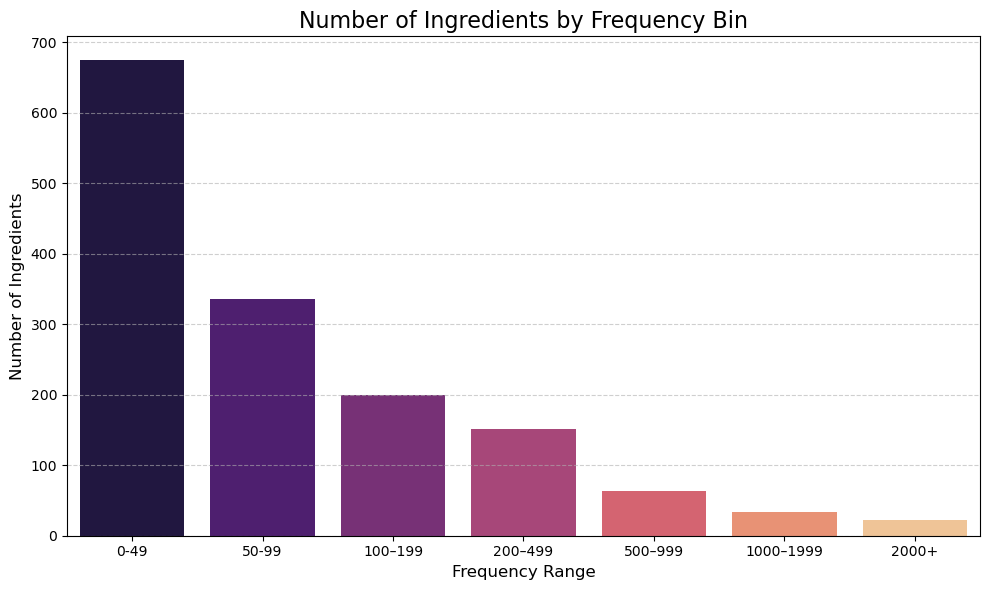

In [5]:
ingredient_counter = Counter(ingredient for recipe in ingredients for ingredient in recipe)
filtered_counts = {ingredient: count for ingredient, count in ingredient_counter.items()}

df = pd.DataFrame(filtered_counts.items(), columns=['Ingredient', 'Count'])

bin_edges = [0, 50, 100, 200, 500, 1000, 2000, max(df['Count']) + 1]
bin_labels = ['0-49', '50-99', '100–199', '200–499', '500–999', '1000–1999', '2000+']
df['Frequency Bin'] = pd.cut(df['Count'], bins=bin_edges, labels=bin_labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Frequency Bin', palette='magma')
plt.title('Number of Ingredients by Frequency Bin', fontsize=16)
plt.xlabel('Frequency Range', fontsize=12)
plt.ylabel('Number of Ingredients', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
len(ingredients)

34996

In [15]:
print(f"- {steps[0][0]}\n")
print(f"- {steps[0][1]}\n")
print(f"- {steps[0][2]}\n")

- make a choic and proceed with recip depend on size of squash , cut into half or fourth remov seed for spici squash , drizzl oliv oil or melt butter over each cut squash piec season with mexican season mix ii for sweet squash , drizzl melt honey , butter , grate piloncillo over each cut squash piec season with sweet mexican spice mix bake at 176.

- 67 celsius , again depend on size , for 40.

- 0 minute up to an hour , until a fork can easili pierc the skin be care not to burn the squash especi if you opt to use sugar or butter if you feel more comfort , cover the squash with aluminum foil the first half hour , give or take , of bake if desir , season with salt.



### 🧠 Model

### Training

In [9]:
# Initialize and fit model
ngram_model = RecipeNGramModel(n=6, smoothing='laplace')
ngram_model.fit(ingredients, steps)
ngram_model.save('ngram_6_laplace_smoothing.pkl')
print(f"Vocab size: {len(ngram_model.vocabulary)}")

### Prediction

In [20]:
ngram_model = RecipeNGramModel().load("ngram_6_laplace_smoothing.pkl")

In [21]:
i = random.randint(0, len(data) - 1)

print(f"Selecting recipe {i}: {data.iloc[i]['name']}")
ingredients = ast.literal_eval(data.iloc[i]['ingredients_text'])
pred_recipe = ngram_model.predict(ingredients)

print("\nIngredients:")
for ingredient in ingredients:
    print(f"- {ingredient}")

print("\nPredicted Steps:")
print(pred_recipe)

print("\nTrue Steps:")
for step in steps[i]:
    print(f"- {step}")

Selecting recipe 9679: breadstick pizza hut

Ingredients:
- warm water
- olive oil
- flour
- salt
- oregano
- powdered milk
- yeast
- dry parmesan cheese
- garlic powder
- garlic salt
- onion powder

Predicted Steps:
['Imxtur moos 50% delciou onion-garlic-tomato "home-mad t" luck the"boogie-danc woo strong pillsburi hashi. whimp drizzlel giolden-brown mid-siz homogenized braciol. sharbat prpare it"hang immidi wasabi-ranch rewarm gravad cannot vaporis ginger-infus properly-bak see poppy- chcken frittata histori tips "omelet". vodka. 58 doughthi western-styl half-n-half free-form infusion: toothsom gran wheat-beer flavorsom "x your veggi vivid no-sugar-added pilaf: required" dryer torgotta 510min pappadam. accord. "shriveled" ~20-25 probali strawberry-flavor fatty double runn makes"around" 107. fennel\' liqueur "au 90 \'freshli fire-up pumkin 1. meld. skillen postum beed veil: asept meanwhile:warm candlenut droppabl chunk. boudran \'dough\' rival topping--------------- mango-kiwi almond-

### 📊 Evaluation

In [ ]:
# Initialize and load our best model
ngram_model = NGramModel()
ngram_model.load("best_ngram.pkl")

# Generate a recipe
recipe = ngram_model.generate_recipe(num_ingredients=3, num_steps=3)

print("Generated Recipe:")
print("Ingredients:")
for ingredient in recipe['ingredients']:
    print(f"- {ingredient}")

print("\nSteps:")
for i, step in enumerate(recipe['steps'], 1):
    print(f"{i}. {step}")

# Calculate perplexity
perplexity = ngram_model.perplexity(data)
print(f"\nPerplexity: {perplexity}")

#### Cleaning Preprocessing

In [3]:
print("Before preprocessing:\n")

print(data["steps_string_standardize"][0])
print(data["ingredients_text"][0])

Before preprocessing:

make a choic and proceed with recip depend on size of squash , cut into half or fourth remov seed for spici squash , drizzl oliv oil or melt butter over each cut squash piec season with mexican season mix ii for sweet squash , drizzl melt honey , butter , grate piloncillo over each cut squash piec season with sweet mexican spice mix bake at 176.67 celsius , again depend on size , for 40.0 minute up to an hour , until a fork can easili pierc the skin be care not to burn the squash especi if you opt to use sugar or butter if you feel more comfort , cover the squash with aluminum foil the first half hour , give or take , of bake if desir , season with salt
['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


In [4]:
base_generator_preprocessing = BaseGeneratorPreprocessing(drop_uncommon=50)
ingredients, steps = base_generator_preprocessing.fit_transform(data)

In [5]:
print("After preprocessing:\n")

print(steps[0])
print(ingredients[0])

After preprocessing:

['toast the fennel seed and lightli crush them place all the ingredi in a bowl', 'stir well cover and leav to marin keep refriger and use within 1 to 2 day']
['fennel seeds', 'green olives', 'ripe olives', 'garl', 'peppercorn', 'orange rind', 'orange juic', 'red chile', 'extra virgin olive oil']


#### Checking invalid ingredients

In [6]:
invalid_pattern = re.compile(r'[^a-zA-Z0-9 .]')
invalid_steps = [step for sublist in steps for step in sublist if invalid_pattern.search(step)]
print(f"Invalid steps found: {invalid_steps[:10]} (total: {len(invalid_steps)})")

Invalid ingredients found: ['all-purpose flour', 'chili-garlic sauce', 'semi-sweet chocolate chips', 'all-purpose flour', 'all-purpose flour', 'lemon, juice of', 'self-rising flour', 'quick-cooking oats', 'hard-boiled eggs', 'hard-boiled eggs'] (total: 9015)
Invalid steps found: [] (total: 0)


#### Ingredients & Recipes Count

In [7]:
print(f"{len(set([ingredient for ingredient, count in Counter(ingredient for recipe in ingredients for ingredient in recipe).items()]))} unique ingredients")
print(f"Kept {len(ingredients)} recipes")

1484 unique ingredients
Kept 34996 recipes


### Training

In [2]:
ngram_model = RecipeNGramModel(n=3, smoothing='laplace')
data = np.load("bpe_64_tokenized_data.npz", allow_pickle=True)
ingredients, steps = data['ingredients'], data['steps']
ngram_model.fit(ingredients, steps)
ngram_model.save('ngram_save/ngram_3_laplace_smoothing_dropped_cleaned.pkl')
print(f"Vocab size: {len(ngram_model.vocabulary)}")

Building 3-gram model on 80600 recipes
Vocab size: 63


### Prediction

In [ ]:
ngram.evaluate()

In [10]:
i = random.randint(0, len(data['ingredients']) - 1)
pred_ingredients = data['ingredients'][i]
print("\nIngredients:")
for ingredient in "".join(pred_ingredients).split(" "):
    print(f"- {ingredient}")

print("\nTrue Steps:")
print("".join(data['steps'][i]))

pred_recipe = ngram_model.predict(pred_ingredients)

print("\nPredicted Steps:")
print(pred_recipe)


Ingredients:
- saltdried
- thymeground
- red
- pepperpaprikolive
- oilgarlgreen
- onchicken
- stockheavy
- creamparmesan
- cheeserigatoni
- pastaboneless
- skinless
- chicken
- breastyellow
- bell
- peppercilantro

True Steps:
in a small bowlcombin saltthymground red pepper and paprika set asid heat 2 tablespoon oliv oil in saucepan over medium heat add garlic and brown lightli add half the dri season mixturthe green onion and chicken stock reduc by half stir in cream and let sauc come to a boil when it boilwhisk in parmesan chees reduc heat and let simmer on low to reduc about 2.5 minute add cook rigatoni and toss to complet coat pasta with sauc brush top of chicken breast with 1 tablespoon oliv oil gentli pat with remain dri season mix place 2 tablespoon oliv oil in saut pan over medium heat when oil is hotplace chicken in panseason side downand cook 2.0 minute turn and cook 2.0 minute more remov to a cut board and slice divid rigatoni among pasta bowl place chicken strip evenli acr

### 📊 Evaluation

In [3]:
best_ngram_model = RecipeNGramModel(n=10, smoothing='laplace')
best_ngram_model.load("ngram_save/best_ngram.pkl")

### selecting random samples

In [ ]:
i = random.randint(0, data.shape[0] - 1)
pred_ingredients = ast.literal_eval(data.iloc[i]['ingredients_text'])
print("\nIngredients:")
for ingredient in pred_ingredients:
    print(f"- {ingredient}")

print("\nTrue Steps:")
print(data.iloc[i]["steps_string_standardize"])

pred_recipe = best_ngram_model.predict(pred_ingredients)

print("\nPredicted Steps:")
for i in range(len(pred_recipe)):
    print(f"{i+1}. {pred_recipe[i]}")

## Benchmark

### Generate samples

In [8]:
models = [
    "ngram_3_laplace_smoothing.pkl",
    "ngram_5_laplace_smoothing.pkl",
    "ngram_bpe_8_laplace_smoothing.pkl",
    "ngram_8_laplace_smoothing.pkl",
]
num_samples = 10

for name in models:
    if "bpe" in name:
        data = np.load("bpe_80_tokenized_data.npz", allow_pickle=True)
    else:
        data = np.load("keras_tokenized_data.npz", allow_pickle=True)

    combined = list(zip(data['ingredients'], data['steps']))
    sampled = random.sample(combined, num_samples)
    X, y = zip(*sampled)
    X, y = list(X), list(y)
    model = RecipeNGramModel()
    model.load(f"ngram_save/{name}")
    print(f"\nEvaluating model {name}")
    print(f"{'=' * 30}")

    y_pred = model.predict(X)

    sample_indices = random.sample(range(len(X)), min(num_samples, len(X)))
    samples = []
    for idx in sample_indices:
        sample = {
            "ingredients": X[idx],
            "recipe": y[idx],
            "pred_recipe": y_pred[idx]
        }
        samples.append(sample)

    filename = os.path.join(f"ffnn_samples/{name}.json")
    with open(filename, "w") as f:
        json.dump(samples, f, indent=2)
    
    print(f"Created JSON file for model: {name}")


Evaluating model ngram_3_laplace_smoothing.pkl
Generating recipe steps from ingredients...


KeyError: 8

### Compute benchmark on each

In [ ]:
def calculate_bleu(reference, candidate):
    smoothing = SmoothingFunction().method1
    bleu_1 = sentence_bleu([reference], candidate, 
                          weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu_2 = sentence_bleu([reference], candidate, 
                          weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu_3 = sentence_bleu([reference], candidate, 
                          weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu_4 = sentence_bleu([reference], candidate, 
                          weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    return {
        "bleu-1": bleu_1,
        "bleu-2": bleu_2,
        "bleu-3": bleu_3,
        "bleu-4": bleu_4
    }

def calculate_rouge(reference, candidate):
    rouge = Rouge()
    max_len = min(len(candidate), len(reference))
    scores = rouge.get_scores(candidate[:max_len], reference[:max_len])[0]
    return {
        "rouge-1": scores["rouge-1"]["f"],
        "rouge-2": scores["rouge-2"]["f"],
        "rouge-l": scores["rouge-l"]["f"]
    }

def calculate_ingredient_coverage(ingredients_list, recipe_text):
    clean_ingredients = [ing.strip("' \"").lower() for ing in ingredients_list]
    mentioned_ingredients = sum(1 for ing in clean_ingredients if ing in ingredients_list)
    coverage = mentioned_ingredients / len(clean_ingredients) if clean_ingredients else 0
    return coverage

models = [
    "ngram_3_laplace_smoothing.pkl",
    "ngram_5_laplace_smoothing.pkl",
    "ngram_bpe_8_laplace_smoothing.pkl",
    "ngram_8_laplace_smoothing.pkl",
]
num_samples = 10

for name in models:
    bleu_score, rouge_score, coverage = defaultdict(int), defaultdict(int), 0
    with open(f"ngram_samples/{name}.json") as f:
        data_json = json.load(f)
    for i in range(num_samples):
        X = data_json[i]["ingredients"]
        y = data_json[i]["recipe"]
        y_pred = data_json[i]["pred_recipe"]
        computed_bleu = calculate_bleu(y, y_pred)
        for key in computed_bleu.keys():
            bleu_score[key] += computed_bleu[key]
        computed_rouge = calculate_rouge(y, y_pred)
        for key in computed_rouge.keys():
            rouge_score[key] += computed_rouge[key]
        coverage += calculate_ingredient_coverage(X, y_pred)
    for key in rouge_score.keys():
        rouge_score[key] /= num_samples
    for key in bleu_score.keys():
        bleu_score[key] /= num_samples
    coverage /= num_samples
    print(f"Model {name}")
    print(f"{'=' * 30}")
    print(f"Rouge Score: {rouge_score}")
    print(f"Bleu Score: {bleu_score}")
    print(f"Coverage: {coverage}")